## Simple Test

In [1]:
from diffusers import DiffusionPipeline,StableDiffusionXLPipeline, AutoencoderKL, ControlNetModel, StableDiffusionXLControlNetPipeline
import torch
from time import perf_counter
import psutil
import gc

def get_device_memory_usage(device=0):
    # 获取 GPU 剩余显存信息
    free_memory, total_memory = torch.cuda.mem_get_info(device)
    free_memory_gb = free_memory / (1024 ** 3)  # 转换为 GB
    total_memory_gb = total_memory / (1024 ** 3)  # 转换为 GB
    used_memory_gb = total_memory_gb - free_memory_gb

    print(f"GPU {device} Memory Usage:")
    print(f"  Total Memory: {total_memory_gb:.2f} GB")
    print(f"  Free Memory: {free_memory_gb:.2f} GB")
    print(f"  Used Memory: {used_memory_gb:.2f} GB")

def get_cpu_memory_usage():
    # 获取 CPU 内存使用情况
    memory_info = psutil.virtual_memory()
    cpu_memory_used = memory_info.used / (1024 ** 3)  # 转换为 GB
    cpu_memory_total = memory_info.total / (1024 ** 3)  # 转换为 GB
    cpu_memory_free = memory_info.available / (1024 ** 3)  # 转换为 GB

    print("CPU Memory Usage:")
    print(f"  Total Memory: {cpu_memory_total:.2f} GB")
    print(f"  Used Memory: {cpu_memory_used:.2f} GB")
    print(f"  Free Memory: {cpu_memory_free:.2f} GB")

def get_gpu_memory_usage():
    # 获取 GPU 显存使用情况
    gpu_memory_allocated = torch.cuda.memory_allocated() / (1024 ** 3)  # 转换为 GB
    gpu_memory_reserved = torch.cuda.memory_reserved() / (1024 ** 3)  # 转换为 GB
    gpu_memory_total = torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)  # 转换为 GB

    print("GPU Memory Usage:")
    print(f"  Total Memory: {gpu_memory_total:.2f} GB")
    print(f"  Allocated Memory: {gpu_memory_allocated:.2f} GB")
    print(f"  Reserved Memory: {gpu_memory_reserved:.2f} GB")

# Example usage
get_cpu_memory_usage()
get_gpu_memory_usage()
get_device_memory_usage()

/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU Memory Usage:
  Total Memory: 62.55 GB
  Used Memory: 7.50 GB
  Free Memory: 54.08 GB
GPU Memory Usage:
  Total Memory: 14.58 GB
  Allocated Memory: 0.00 GB
  Reserved Memory: 0.00 GB
GPU 0 Memory Usage:
  Total Memory: 14.58 GB
  Free Memory: 14.48 GB
  Used Memory: 0.10 GB


In [2]:
start = perf_counter()
pipe = DiffusionPipeline.from_pretrained("/data1/workspace/javeyqiu/models/stable-diffusion-xl-base-1.0", 
                                         torch_dtype=torch.float16, 
                                         use_safetensors=True, 
                                         variant="fp16").to("cuda")
endtime = perf_counter()-start
print("加载一个 SD-XL 基座模型 所需时间为: ", endtime, "s")
get_cpu_memory_usage()
get_gpu_memory_usage()

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


加载一个 SD-XL 基座模型 所需时间为:  2.1533571677282453 s
CPU Memory Usage:
  Total Memory: 62.55 GB
  Used Memory: 10.08 GB
  Free Memory: 51.49 GB
GPU Memory Usage:
  Total Memory: 14.58 GB
  Allocated Memory: 6.57 GB
  Reserved Memory: 6.80 GB


In [ ]:
prompt = "An astronaut riding a horse"
negative_prompt = None
width = 1024
height = 1024
steps = 20

images = pipe(prompt=prompt,
            negative_prompt=negative_prompt,
            height=height,
            width=width,
            num_images_per_prompt=1,
            num_inference_steps=steps).images
get_gpu_memory_usage()

In [3]:
from diffusers import StableDiffusionXLPipeline, AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTokenizer, CLIPTextModel, CLIPTextModelWithProjection

text_encoder = CLIPTextModel.from_pretrained(
  '/data1/workspace/javeyqiu/models/stable-diffusion-xl-base-1.0',
  subfolder='text_encoder',
  use_safetensors=True,
  torch_dtype=torch.float16,
  variant='fp16',
).to("cuda")
text_encoder_2 = CLIPTextModelWithProjection.from_pretrained(
  '/data1/workspace/javeyqiu/models/stable-diffusion-xl-base-1.0',
  subfolder='text_encoder_2',
  use_safetensors=True,
  torch_dtype=torch.float16,
  variant='fp16',
).to("cuda")
unet = UNet2DConditionModel.from_pretrained(
    "/data1/workspace/javeyqiu/models/stable-diffusion-xl-base-1.0",
    subfolder='unet',
    torch_dtype=torch.float16, 
    use_safetensors=True, 
    variant="fp16"
).to("cuda")
vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix", 
    torch_dtype=torch.float16,
    cache_dir='/data1/workspace/javeyqiu/models/huggingface/hub'
).to("cuda")


In [4]:
start = perf_counter()
pipe = StableDiffusionXLPipeline.from_pretrained(
    "/data1/workspace/javeyqiu/models/stable-diffusion-xl-base-1.0", 
    unet=unet,
    vae=vae,
    text_encoder=text_encoder,
    text_encoder_2=text_encoder_2,
    use_safetensors=True, 
    torch_dtype=torch.float16, 
    variant="fp16"
)
endtime = perf_counter()-start
print("加载一个 SD-XL 基座模型 所需时间为: ", endtime, "s")

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 45.67it/s]

加载一个 SD-XL 基座模型 所需时间为:  0.1581201134249568 s
Max memory allocated: 6.5670599937438965 GB


In [ ]:
start = perf_counter()
controlnet_depth = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
    cache_dir='/data1/workspace/javeyqiu/models/huggingface/hub'
).to("cuda")

pipe_depth = StableDiffusionXLControlNetPipeline.from_pipe(
    pipe,
    controlnet=controlnet_depth,
)

endtime = perf_counter()-start
print("增加一个 controlnet pipe所需时间为: ", endtime, "s")
get_cpu_memory_usage()
get_gpu_memory_usage()

### Canny

In [2]:
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL
from diffusers.utils import load_image
from PIL import Image
import torch
import numpy as np
import cv2
import gc
from time import perf_counter
def bytes_to_giga_bytes(bytes):
    return bytes / 1024 / 1024 / 1024

start = perf_counter()

controlnet_canny = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0",
    torch_dtype=torch.float16,
    cache_dir='/data1/workspace/javeyqiu/models/huggingface/hub',
).to("cuda")
vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix", 
    torch_dtype=torch.float16,
    cache_dir='/data1/workspace/javeyqiu/models/huggingface/hub'
).to("cuda")
pipe_canny = StableDiffusionXLControlNetPipeline.from_pretrained(
    "/data1/workspace/javeyqiu/models/stable-diffusion-xl-base-1.0",
    controlnet=controlnet_canny,
    vae=vae,
    torch_dtype=torch.float16,
).to("cuda")
# pipe.enable_model_cpu_offload()

endtime = perf_counter()-start
print("加载完一个 controlnet pipe所需时间为: ", endtime, "s")
get_cpu_memory_usage()
get_gpu_memory_usage()

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]


加载完一个 controlnet pipe所需时间为:  5.1450941930525005 s
CPU Memory Usage:
  Total Memory: 62.55 GB
  Used Memory: 15.07 GB
  Free Memory: 46.38 GB
GPU Memory Usage:
  Total Memory: 14.58 GB
  Allocated Memory: 8.97 GB
  Reserved Memory: 9.25 GB


In [4]:
get_cpu_memory_usage()
get_gpu_memory_usage()

CPU Memory Usage:
  Total Memory: 62.55 GB
  Used Memory: 15.09 GB
  Free Memory: 46.36 GB
GPU Memory Usage:
  Total Memory: 14.58 GB
  Allocated Memory: 6.59 GB
  Reserved Memory: 7.81 GB


In [3]:
del controlnet_canny
del pipe_canny.controlnet
gc.collect()
torch.cuda.empty_cache()

In [15]:
from diffusers import StableDiffusionXLPipeline
prompt = "An astronaut riding a horse"
negative_prompt = None
width = 1024
height = 1024
steps = 20
def remove_key_from_dict(mydict, key_to_delete):
    del mydict[key_to_delete]
    return mydict
pipe = StableDiffusionXLPipeline(**remove_key_from_dict(pipe_canny.components, 'controlnet'))
images = pipe(prompt=prompt,
            negative_prompt=negative_prompt,
            height=height,
            width=width,
            num_images_per_prompt=1,
            num_inference_steps=steps).images

In [3]:
start = perf_counter()
controlnet_depth = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
    cache_dir='/data1/workspace/javeyqiu/models/huggingface/hub'
).to("cuda")

pipe_depth = StableDiffusionXLControlNetPipeline.from_pipe(
    pipe_canny,
    controlnet=controlnet_depth,
)
# pipe_canny.controlnet = controlnet_depth

endtime = perf_counter()-start
print("更换一个 controlnet pipe所需时间为: ", endtime, "s")

更换一个 controlnet pipe所需时间为:  1.2764649908058345 s


In [4]:
get_cpu_memory_usage()
get_gpu_memory_usage()

CPU Memory Usage:
  Total Memory: 62.55 GB
  Used Memory: 15.20 GB
  Free Memory: 46.25 GB
GPU Memory Usage:
  Total Memory: 14.58 GB
  Allocated Memory: 11.33 GB
  Reserved Memory: 11.70 GB


In [6]:
prompt = "aerial view, a futuristic research complex in a bright foggy jungle, hard lighting"
negative_prompt = 'low quality, bad quality, sketches'

#  image = load_image("https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd_controlnet/hf-logo.png")
image = cv2.imread('hf-logo.png')

controlnet_conditioning_scale = 0.5  # recommended for good generalization

image = np.array(image)
image = cv2.Canny(image, 100, 200)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
image = Image.fromarray(image)

images = pipe_canny(
    prompt, negative_prompt=negative_prompt, image=image, controlnet_conditioning_scale=controlnet_conditioning_scale,
    num_inference_steps=20,
    ).images

images[0].save(f"hug_lab.png")
print(f"Max memory allocated: {bytes_to_giga_bytes(torch.cuda.max_memory_allocated())} GB")


100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Max memory allocated: 13.425424575805664 GB


## Depth

In [1]:
import torch
import numpy as np
import cv2
from PIL import Image

from transformers import DPTFeatureExtractor, DPTForDepthEstimation
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL
from diffusers.utils import load_image
from time import perf_counter
def bytes_to_giga_bytes(bytes):
    return bytes / 1024 / 1024 / 1024

start = perf_counter()

depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas",
                                                        cache_dir='/data1/workspace/javeyqiu/models/huggingface/hub'
                                                        ).to("cuda")
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas",
                                                        cache_dir='/data1/workspace/javeyqiu/models/huggingface/hub'
                                                        )
controlnet_depth = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
    cache_dir='/data1/workspace/javeyqiu/models/huggingface/hub'
).to("cuda")
vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix", 
    torch_dtype=torch.float16,
    cache_dir='/data1/workspace/javeyqiu/models/huggingface/hub'
).to("cuda")
pipe_depth = StableDiffusionXLControlNetPipeline.from_pretrained(
    "/data1/workspace/javeyqiu/models/stable-diffusion-xl-base-1.0",
    controlnet=controlnet_depth,
    vae=vae,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to("cuda")
# pipe.enable_model_cpu_offload()

endtime = perf_counter()-start
print("加载完一个 controlnet pipe所需时间为: ", endtime, "s")
print(f"Max memory allocated: {bytes_to_giga_bytes(torch.cuda.max_memory_allocated())} GB")

/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


加载完一个 controlnet pipe所需时间为:  6.267863660119474 s
Max memory allocated: 9.404163837432861 GB


In [10]:
import gc
del pipe_depth.controlnet
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
print(f"Max memory allocated: {bytes_to_giga_bytes(torch.cuda.max_memory_allocated())} GB")

Max memory allocated: 11.775209903717041 GB


In [8]:
start = perf_counter()
# controlnet_canny = ControlNetModel.from_pretrained(
#     "diffusers/controlnet-canny-sdxl-1.0",
#     torch_dtype=torch.float16,
#     cache_dir='/data1/workspace/javeyqiu/models/huggingface/hub',
# ).to("cuda")
controlnet_canny = torch.load('controlnet_canny.pt').to("cuda")
pipe_canny = StableDiffusionXLControlNetPipeline.from_pipe(
    pipe_depth,
    controlnet=controlnet_canny,
)

endtime = perf_counter()-start
print("更换一个 controlnet pipe所需时间为: ", endtime, "s")
print(f"Max memory allocated: {bytes_to_giga_bytes(torch.cuda.max_memory_allocated())} GB")

更换一个 controlnet pipe所需时间为:  0.9823811422102153 s
Max memory allocated: 11.775209903717041 GB


/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `controlnet` directly via 'StableDiffusionXLControlNetPipeline' object attribute is deprecated. Please access 'controlnet' over 'StableDiffusionXLControlNetPipeline's config object instead, e.g. 'scheduler.config.controlnet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


In [12]:
controlnet_canny.to('cpu')

start = perf_counter()
controlnet_canny.to('cuda')
endtime = perf_counter()-start
print("更换一个 controlnet pipe所需时间为: ", endtime, "s")

更换一个 controlnet pipe所需时间为:  0.2794498852454126 s


In [11]:
def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to("cuda")
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)

    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image


prompt = "stormtrooper lecture, photorealistic"
# image = load_image("https://huggingface.co/lllyasviel/sd-controlnet-depth/resolve/main/images/stormtrooper.png")
image = cv2.imread('stormtrooper.png')

controlnet_conditioning_scale = 0.5  # recommended for good generalization

depth_image = get_depth_map(image)

images = pipe_depth(
    prompt, image=depth_image, num_inference_steps=30, controlnet_conditioning_scale=controlnet_conditioning_scale,
).images
images[0]

images[0].save(f"stormtrooper_trans.png")

100%|██████████| 30/30 [00:33<00:00,  1.11s/it]


In [ ]:
from diffusers import UNet2DConditionModel
import torch

model = UNet2DConditionModel.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", 
                                         torch_dtype=torch.float16, 
                                         use_safetensors=True, 
                                         variant="fp16").to("cuda")
print(model)

In [2]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", 
                                         torch_dtype=torch.float16, 
                                         use_safetensors=True, 
                                         variant="fp16").to("cuda") 

/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pyt

In [ ]:
unet_model = pipe.unet
print(unet_model)

In [ ]:
# 定义示例输入
sample = torch.randn(1, 4, 64, 64).half().to("cuda")
timestep = torch.Tensor(1.).half().to("cuda")
encoder_hidden_states = torch.randn(1, 64, 64).half().to("cuda")
added_cond_kwargs = {'text_embeds': }

# 使用 torch.jit.trace() 跟踪模型
traced_model = torch.jit.trace(unet_model, (sample, timestep, encoder_hidden_states))

# 打印跟踪后的模型
print(traced_model)

In [ ]:
prompt = "An astronaut riding a horse"
negative_prompt = None
width = 1024
height = 1024
steps = 20

images = pipe(prompt=prompt,
                    negative_prompt=negative_prompt,
                    height=height,
                    width=width,
                    num_images_per_prompt=1,
                    num_inference_steps=steps).images

# Comparison

In [ ]:
from safetensors.torch import load_file

### Baseline

In [3]:
from time import perf_counter
from diffusers import  AutoPipelineForText2Image, AutoencoderKL
import torch

width = 1024
height = 1024
steps = 30

queue = [{
  'prompt': 'An astronaut riding a horse',
  'seed': 20240708,
}]

queue.extend([{
  'prompt': 'Watercolor painting of a desert landscape, with sand dunes, mountains, and a blazing sun, soft and delicate brushstrokes, warm and vibrant colors',
  'seed': 20240708,
}])

queue.extend([{
  'prompt': '3/4 shot, candid photograph of a beautiful 30 year old redhead woman with messy dark hair, peacefully sleeping in her bed, night, dark, light from window, dark shadows, masterpiece, uhd, moody',
  'seed': 877866765,
}])

queue.extend([{
  'prompt': '3d rendered isometric fiji island beach, 3d tile, polygon, cartoony, mobile game',
  'seed': 987867834,
}])

negative_prompt = "(EasyNegative),(watermark), (signature), (sketch by bad-artist), (signature), (worst quality), (low quality), (bad anatomy), NSFW, nude, (normal quality)"


In [5]:
# it's already disabled by default
# torch.backends.cuda.matmul.allow_tf32 = False
# torch.bfloat16

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", 
    torch_dtype=torch.float16, 
    use_safetensors=True, 
    variant="fp16"
    ).to("cuda")

# Create a generator
generator = torch.Generator(device='cuda')

# warm up
for generation in queue:
    pipe(generation['prompt'], num_inference_steps=20)
    
for i, generation in enumerate(queue, start=1):
    image_start = perf_counter()
    # Assign the seed to the generator
    generator.manual_seed(generation['seed'])
    # Create the image
    image = pipe(prompt=generation['prompt'],
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_images_per_prompt=1,
                num_inference_steps=steps,
                ).images[0]
    # Save the image
    image.save(f'./image_save/image_{i}.png')
    generation['total_time'] = perf_counter() - image_start

# Print the generation time of each image
images_totals = ', '.join(map(lambda generation: str(round(generation['total_time'], 1)), queue))
print('Total Image time:', images_totals)

# Print the average time
images_average = round(sum(generation['total_time'] for generation in queue) / len(queue), 1)
print('Average image time:', images_average)

max_memory = round(torch.cuda.max_memory_allocated(device='cuda') / 1000000000, 2)
print('Max. memory used:', max_memory, 'GB')

100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Total Image time: 17.9
Average image time: 17.9
Max. memory used: 14.03 GB


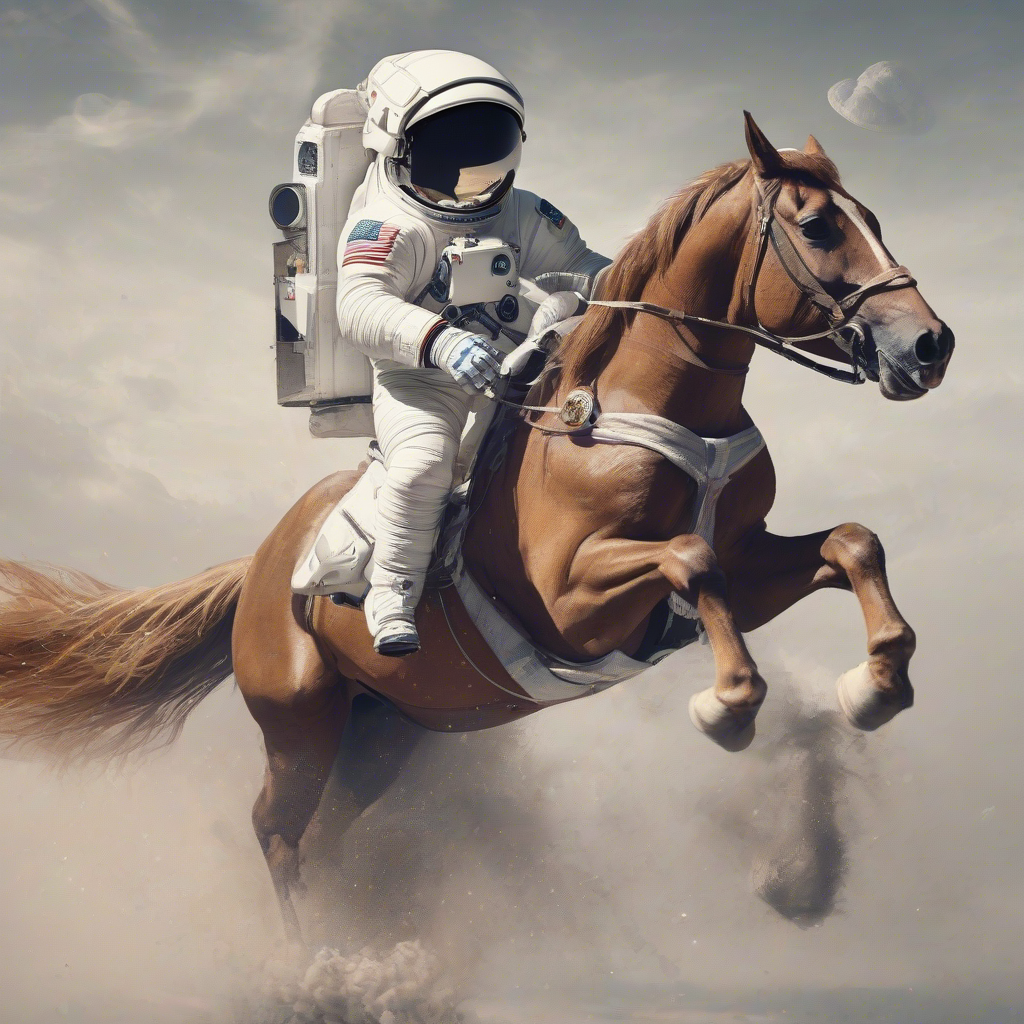

In [6]:
image

In [3]:
# vae_fp16_fix

vae = AutoencoderKL.from_pretrained(
  'madebyollin/sdxl-vae-fp16-fix',
  use_safetensors=True,
  torch_dtype=torch.float16,
).to('cuda')

pipe = AutoPipelineForText2Image.from_pretrained(
  'stabilityai/stable-diffusion-xl-base-1.0',
  use_safetensors=True,
  torch_dtype=torch.float16,
  variant='fp16',
  vae=vae,
).to('cuda')

# Create a generator
generator = torch.Generator(device='cuda')

# warm up
for generation in queue:
    pipe(generation['prompt'], num_inference_steps=20)
    
for i, generation in enumerate(queue, start=1):
    image_start = perf_counter()
    # Assign the seed to the generator
    generator.manual_seed(generation['seed'])
    # Create the image
    image = pipe(prompt=generation['prompt'],
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_images_per_prompt=1,
                num_inference_steps=steps,
                ).images[0]
    # Save the image
    image.save(f'./image_save/image_{i}.png')
    generation['total_time'] = perf_counter() - image_start

# Print the generation time of each image
images_totals = ', '.join(map(lambda generation: str(round(generation['total_time'], 1)), queue))
print('Total Image time:', images_totals)

# Print the average time
images_average = round(sum(generation['total_time'] for generation in queue) / len(queue), 1)
print('Average image time:', images_average)

max_memory = round(torch.cuda.max_memory_allocated(device='cuda') / 1000000000, 2)
print('Max. memory used:', max_memory, 'GB')

100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Total Image time: 17.0, 17.3, 17.3
Average image time: 17.2
Max. memory used: 9.62 GB


In [1]:
from time import perf_counter
from diffusers import  AutoPipelineForText2Image, AutoencoderKL
import torch

width = 1024
height = 1024
steps = 30

queue = [{
  'prompt': 'An astronaut riding a horse',
  'seed': 20240708,
}]

queue.extend([{
  'prompt': 'Watercolor painting of a desert landscape, with sand dunes, mountains, and a blazing sun, soft and delicate brushstrokes, warm and vibrant colors',
  'seed': 20240708,
}])

queue.extend([{
  'prompt': '3/4 shot, candid photograph of a beautiful 30 year old redhead woman with messy dark hair, peacefully sleeping in her bed, night, dark, light from window, dark shadows, masterpiece, uhd, moody',
  'seed': 877866765,
}])

queue.extend([{
  'prompt': '3d rendered isometric fiji island beach, 3d tile, polygon, cartoony, mobile game',
  'seed': 987867834,
}])
negative_prompt = "(EasyNegative),(watermark), (signature), (sketch by bad-artist), (signature), (worst quality), (low quality), (bad anatomy), NSFW, nude, (normal quality)"


/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pyt

In [2]:
# Set the following compiler flags to make things go brrr.
torch._inductor.config.conv_1x1_as_mm = True
torch._inductor.config.coordinate_descent_tuning = True
torch._inductor.config.epilogue_fusion = False
torch._inductor.config.coordinate_descent_check_all_directions = True

In [ ]:
pipe = AutoPipelineForText2Image.from_pretrained(
  'stabilityai/stable-diffusion-xl-base-1.0',
  use_safetensors=True,
  torch_dtype=torch.float16,
  variant='fp16',
).to('cuda')

# mode='reduce-overhead' ? 'max-autotune'
# 'max-autotune' uses CUDA graphs and optimizes the compilation graph specifically for latency

# Specifying  'fullgraph' to be 'True' ensures that there are no graph breaks 
# in the underlying model, ensuring the fullest potential of torch.compile

# pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)
## Compile the UNet and VAE.
pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)
pipe.vae.decode = torch.compile(pipe.vae.decode, mode="reduce-overhead", fullgraph=True)

generator = torch.Generator(device='cuda')

# # warm up
# for generation in queue:
#     pipe(generation['prompt'], 
#          negative_prompt=negative_prompt,
#          num_inference_steps=20)
# pipe(prompt='An astronaut riding a horse', 
#          negative_prompt=negative_prompt,
#          num_inference_steps=20)

for i, generation in enumerate(queue, start=1):
    image_start = perf_counter()
    generator.manual_seed(generation['seed'])
    image = pipe(prompt=generation['prompt'],
                  negative_prompt=negative_prompt,
                  height=height,
                  width=width,
                  num_images_per_prompt=1,
                  num_inference_steps=steps,
                  ).images[0]
    image.save(f'image_{i}.png')

    generation['total_time'] = perf_counter() - image_start

images_totals = ', '.join(map(lambda generation: str(round(generation['total_time'], 1)), queue))
print('Image time:', images_totals)

images_average = round(sum(generation['total_time'] for generation in queue) / len(queue), 1)
print('Average image time:', images_average)

max_memory = round(torch.cuda.max_memory_allocated(device='cuda') / 1000000000, 2)
print('Max. memory used:', max_memory, 'GB')

## 工程优化
### 模型CPU卸载
### 

### Stable Fast

In [7]:
import xformers
import triton
from sfast.compilers.diffusion_pipeline_compiler import (compile, CompilationConfig)


pipe = AutoPipelineForText2Image.from_pretrained(
  'stabilityai/stable-diffusion-xl-base-1.0',
  use_safetensors=True,
  torch_dtype=torch.float16,
  variant='fp16',
).to('cuda')

config = CompilationConfig.Default()

config.enable_xformers = True
config.enable_triton = True
config.enable_cuda_graph = True

compile_start = perf_counter()
pipe = compile(pipe, config)
print('Compile time:', round(perf_counter() - compile_start, 1))

generator = torch.Generator(device='cuda')

# warm up
for generation in queue:
    pipe(generation['prompt'], num_inference_steps=20)

for i, generation in enumerate(queue, start=1):
    image_start = perf_counter()
    # Assign the seed to the generator
    generator.manual_seed(generation['seed'])
    # Create the image
    image = pipe(prompt=generation['prompt'],
                  negative_prompt=negative_prompt,
                  height=height,
                  width=width,
                  num_images_per_prompt=1,
                  num_inference_steps=steps,
                  ).images[0]
    # Save the image
    image.save(f'./image_save/image_{i}.png')
    generation['total_time'] = perf_counter() - image_start

# Print the generation time of each image
images_totals = ', '.join(map(lambda generation: str(round(generation['total_time'], 1)), queue))
print('Total Image time:', images_totals)

# Print the average time
images_average = round(sum(generation['total_time'] for generation in queue) / len(queue), 1)
print('Average image time:', images_average)

max_memory = round(torch.cuda.max_memory_allocated(device='cuda') / 1000000000, 2)
print('Max. memory used:', max_memory, 'GB')

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Compile time: 0.1


/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/sfast/jit/overrides.py:21: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return func(*args, **kwargs)
/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/sfast/jit/overrides.py:21: TracerWarning: Converting a tensor to a Python list might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return func(*args, **kwargs)
/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/sfast/jit/overrides.py:21: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't 

Total Image time: 17.2
Average image time: 17.2
Max. memory used: 14.09 GB


### DeepCache 深度缓存

有两个参数可以修改以实现更快的速度，尽管会导致结果质量的更大损失。

 - cache_interval=3 指定缓存以步骤为单位更新的频率，越小越好。。
 - cache_branch_id=0 指定神经网络的哪个分支负责执行缓存过程（按降序排列， 0 是第一层）。

In [1]:
from time import perf_counter
from diffusers import DiffusionPipeline, AutoPipelineForText2Image
import torch

queue = [{
  'prompt': 'An astronaut riding a horse',
  'seed': 20240708,
}]

negative_prompt = None
width = 1024
height = 1024
steps = 20

/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data1/workspace/javeyqiu/miniconda/envs/sd-xl/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pyt

In [2]:
from DeepCache import DeepCacheSDHelper

pipe = AutoPipelineForText2Image.from_pretrained(
  'stabilityai/stable-diffusion-xl-base-1.0',
  use_safetensors=True,
  torch_dtype=torch.float16,
  variant='fp16',
).to('cuda')

helper = DeepCacheSDHelper(pipe=pipe)
# cache_interval=3, cache_branch_id=0
# cache_branch_id
helper.set_params(cache_interval=2, cache_branch_id=0)
helper.enable()

generator = torch.Generator(device='cuda')

# warm up
for generation in queue:
    pipe(generation['prompt'], num_inference_steps=20)

for i, generation in enumerate(queue, start=1):
    image_start = perf_counter()
    # Assign the seed to the generator
    generator.manual_seed(generation['seed'])
    # Create the image
    image = pipe(prompt=generation['prompt'],
                  negative_prompt=negative_prompt,
                  height=height,
                  width=width,
                  num_images_per_prompt=1,
                  num_inference_steps=steps,
                  ).images[0]
    # Save the image
    image.save(f'./image_save/image_{i}.png')
    generation['total_time'] = perf_counter() - image_start

# Print the generation time of each image
images_totals = ', '.join(map(lambda generation: str(round(generation['total_time'], 1)), queue))
print('Total Image time:', images_totals)

# Print the average time
images_average = round(sum(generation['total_time'] for generation in queue) / len(queue), 1)
print('Average image time:', images_average)

max_memory = round(torch.cuda.max_memory_allocated(device='cuda') / 1000000000, 2)
print('Max. memory used:', max_memory, 'GB')

100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Total Image time: 10.4
Average image time: 10.4
Max. memory used: 10.78 GB


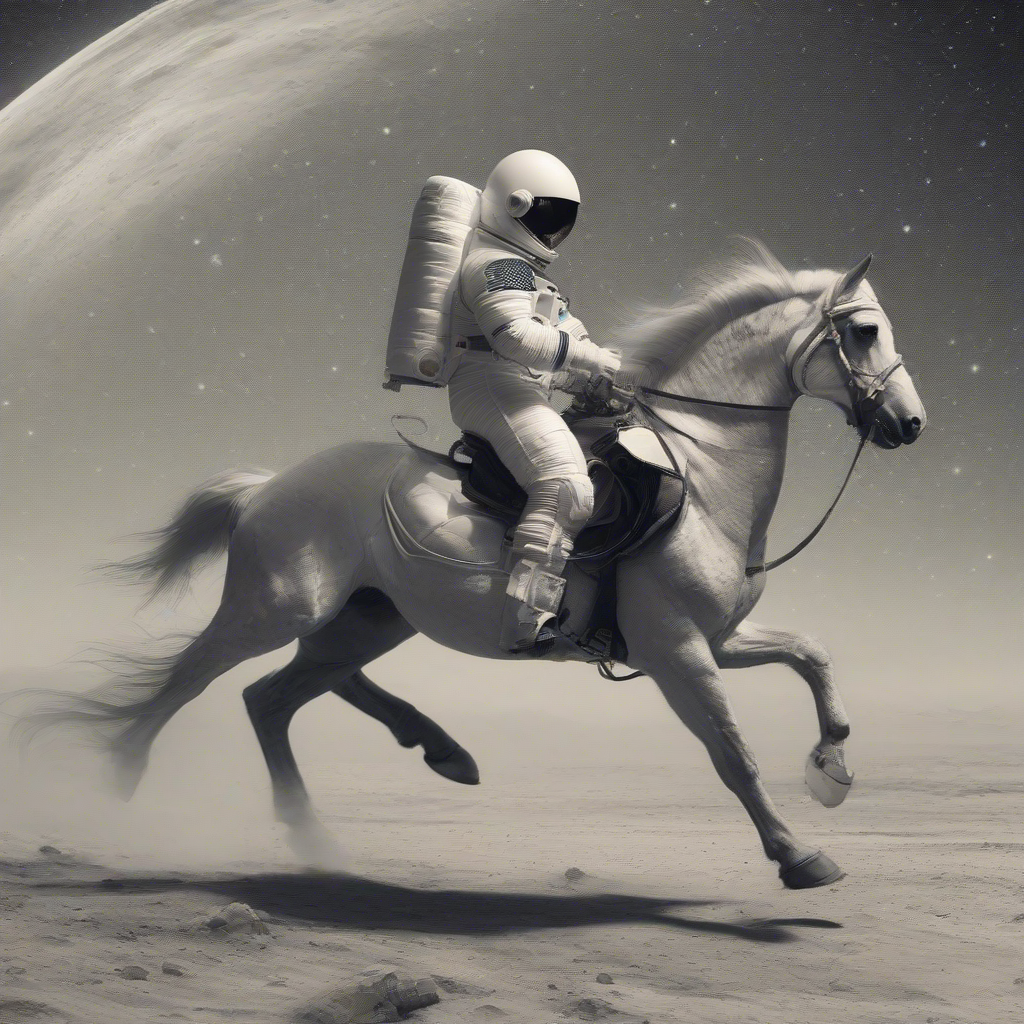

In [3]:
image

In [ ]:
from time import perf_counter
import gc
import torch
from transformers import CLIPTokenizer, CLIPTextModel, CLIPTextModelWithProjection
from diffusers import AutoPipelineForText2Image

def encode_prompt(prompts, tokenizers, text_encoders):
  embeddings_list = []

  for prompt, tokenizer, text_encoder in zip(prompts, tokenizers, text_encoders):
    cond_input = tokenizer(
      prompt,
      max_length=tokenizer.model_max_length,
      padding='max_length',
      truncation=True,
      return_tensors='pt',
    )

    prompt_embeds = text_encoder(cond_input.input_ids.to('cuda'), output_hidden_states=True)

    pooled_prompt_embeds = prompt_embeds[0]
    embeddings_list.append(prompt_embeds.hidden_states[-2])

  prompt_embeds = torch.concat(embeddings_list, dim=-1)

  negative_prompt_embeds = torch.zeros_like(prompt_embeds)
  negative_pooled_prompt_embeds = torch.zeros_like(pooled_prompt_embeds)

  bs_embed, seq_len, _ = prompt_embeds.shape
  prompt_embeds = prompt_embeds.repeat(1, 1, 1)
  prompt_embeds = prompt_embeds.view(bs_embed * 1, seq_len, -1)

  seq_len = negative_prompt_embeds.shape[1]
  negative_prompt_embeds = negative_prompt_embeds.repeat(1, 1, 1)
  negative_prompt_embeds = negative_prompt_embeds.view(1 * 1, seq_len, -1)

  pooled_prompt_embeds = pooled_prompt_embeds.repeat(1, 1).view(bs_embed * 1, -1)
  negative_pooled_prompt_embeds = negative_pooled_prompt_embeds.repeat(1, 1).view(bs_embed * 1, -1)

  return prompt_embeds, negative_prompt_embeds, pooled_prompt_embeds, negative_pooled_prompt_embeds

queue = []

queue.extend([{
  'prompt': '3/4 shot, candid photograph of a beautiful 30 year old redhead woman with messy dark hair, peacefully sleeping in her bed, night, dark, light from window, dark shadows, masterpiece, uhd, moody',
  'seed': 877866765,
}])

queue.extend([{
  'prompt': 'futuristic living room with big windows, brown sofas, coffee table, plants, cyberpunk city, concept art, earthy colors',
  'seed': 5567822456,
}])

queue.extend([{
  'prompt': 'macro shot of a bee collecting nectar from lavender flowers',
  'seed': 2257899453,
}])

queue.extend([{
  'prompt': '3d rendered isometric fiji island beach, 3d tile, polygon, cartoony, mobile game',
  'seed': 987867834,
}])

tokenizer = CLIPTokenizer.from_pretrained(
  'stabilityai/stable-diffusion-xl-base-1.0',
  subfolder='tokenizer',
)

text_encoder = CLIPTextModel.from_pretrained(
  'stabilityai/stable-diffusion-xl-base-1.0',
  subfolder='text_encoder',
  use_safetensors=True,
  torch_dtype=torch.float16,
  variant='fp16',
).to('cuda')

tokenizer_2 = CLIPTokenizer.from_pretrained(
  'stabilityai/stable-diffusion-xl-base-1.0',
  subfolder='tokenizer_2',
)

text_encoder_2 = CLIPTextModelWithProjection.from_pretrained(
  'stabilityai/stable-diffusion-xl-base-1.0',
  subfolder='text_encoder_2',
  use_safetensors=True,
  torch_dtype=torch.float16,
  variant='fp16',
).to('cuda')

with torch.no_grad():
  for generation in queue:
    image_start = perf_counter()

    generation['embeddings'] = encode_prompt(
      [generation['prompt'], generation['prompt']],
      [tokenizer, tokenizer_2],
      [text_encoder, text_encoder_2],
    )

    generation['total_time'] = perf_counter() - image_start

del tokenizer, text_encoder, tokenizer_2, text_encoder_2
gc.collect()
torch.cuda.empty_cache()

pipe = AutoPipelineForText2Image.from_pretrained(
  'stabilityai/stable-diffusion-xl-base-1.0',
  use_safetensors=True,
  torch_dtype=torch.float16,
  variant='fp16',
  tokenizer=None,
  text_encoder=None,
  tokenizer_2=None,
  text_encoder_2=None,
).to('cuda')

generator = torch.Generator(device='cuda')

# warm up
for generation in queue:
  pipe(
    prompt_embeds=generation['embeddings'][0],
    negative_prompt_embeds =generation['embeddings'][1],
    pooled_prompt_embeds=generation['embeddings'][2],
    negative_pooled_prompt_embeds=generation['embeddings'][3],
    output_type='latent',
  )

for i, generation in enumerate(queue, start=1):
  image_start = perf_counter()

  generator.manual_seed(generation['seed'])

  generation['latents'] = pipe(
    prompt_embeds=generation['embeddings'][0],
    negative_prompt_embeds =generation['embeddings'][1],
    pooled_prompt_embeds=generation['embeddings'][2],
    negative_pooled_prompt_embeds=generation['embeddings'][3],
    generator=generator,
    output_type='latent',
  ).images

  generation['total_time'] = generation['total_time'] + (perf_counter() - image_start)

del pipe.unet
gc.collect()
torch.cuda.empty_cache()

pipe.upcast_vae()

with torch.no_grad():
  for i, generation in enumerate(queue, start=1):
    image_start = perf_counter()

    generation['latents'] = generation['latents'].to(next(iter(pipe.vae.post_quant_conv.parameters())).dtype)

    image = pipe.vae.decode(
      generation['latents'] / pipe.vae.config.scaling_factor,
      return_dict=False,
    )[0]

    image = pipe.image_processor.postprocess(image, output_type='pil')[0]
    image.save(f'image_{i}.png')

    generation['total_time'] = generation['total_time'] + (perf_counter() - image_start)

images_totals = ', '.join(map(lambda generation: str(round(generation['total_time'], 1)), queue))
print('Image time:', images_totals)

images_average = round(sum(generation['total_time'] for generation in queue) / len(queue), 1)
print('Average image time:', images_average)

max_memory = round(torch.cuda.max_memory_allocated(device='cuda') / 1000000000, 2)
print('Max. memory used:', max_memory, 'GB')